# The Battle of Neighborhoods – Capstone Project
-----------------------

## Business Problem:
Let’s say we have a client who’s interested in opening an Indian restaurant in New York city and is also planning to branch out into the surrounding boroughs. The client wants to start small but is expecting to generate very good profits so that could boost the confidence besides profits made, to set up another branch. Given that New York city is vast and the presence of many top, aggressive competitors, the client wants us to analyze the neighborhoods and analyze competitors and the areas that could help in the process of making business decisions as to where to start off for making very good profits and where to branch out next.

---------------------------------------

## Introduction:
New York City’s demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.
According to 2007 American Community Survey estimates, New York City is home to approximately 236,117 people from the India. With its diverse culture, comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese, Indian, French etc.
We will analyze all major parts of New York City that has Indian restaurants and try to figure out what business decisions and strategies could be made for our client, to set up an Indian restaurant and expand business.

According to 2007 American Community Survey estimates, New York City is home to approximately 236,117 people from the India. With its diverse culture, comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese, Indian, French etc.
We will analyze all major parts of New York City that has Indian restaurants and try to figure out what business decisions and strategies could be made for our client, to set up an Indian restaurant and expand business.

--------------

## Data:
We will be utilizing the following data:
- New York City dataset in the form of JSON file that contains list Boroughs, Neighborhoods along with their latitude and longitude. We will need to convert it to a dataframe and extract all the necessary attributes such as Neighborhood, Borough, Coordinates etc.
	Data source: https://cocl.us/new_york_dataset
- A list of Indian Restaurants in each neighborhood of New York city. By using the Foursquare API, we will fetch the venues in each neighborhood. We can filter these venues to get only the list of Indian Restaurants and analyze as per the neighborhoods. We then also extract the ratings of the respective venues to figure out the competitors’ reputation and quality of food or service using Foursqaure’s premium API calls. We finally put the results together from both the analysis and come up possible business decisions to be proposed to the client.
	Data source: Foursquare API calls.

------------

## Methodology:

We will extract restaurant venues as per the neighborhoods, analyze their ratings and also visualize them on the map to see that distribution of the places in respective boroughs and make business decisions based on the final results.

-----------

#### Let's go ahead and start with importing all the necessary libraries

In [25]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


#### Now, we will be using some imporant functions like fetching Latitude, Longitude for a given address, utilizing Foursqaure's API calls often. So, let's define some functions for the same purpose.

In [6]:
def geo_location(address):
    """
    This functoin will return coordinated for the given address
    """
    geolocator = Nominatim(user_agent='ny_explorer')
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude

#### Let's assume the client wants top venues serving Indian food within 1500 metres of a given coordinate.

In [34]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [78]:
def get_venues(lat,long):
    """
    This functioon will take coordinates as inputs and returns a dataframe with venue id, name and category.
    """
    radius = 1500
    LIMIT = 100
    CLIENT_ID = '2PP4EVO3RUPV5AQSUGVXPYXVN4JXYDI2KBOM3QWZMHEQMMLS' # Foursquare ID
    CLIENT_SECRET = 'AJF3VHPGS04IBRDSXC10BSUKLX3SSG11CJOMBT44ZC4QJSY2' # Foursquare Secret
    VERSION = '20180605'
    
    #URL to be used to to fetch the result and convert to JSON
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius, 
        LIMIT)
    
    result = requests.get(url).json()
    venue_list = result['response']['groups'][0]['items']
    nearby_venues = json_normalize(venue_list) # flatten JSON
    
    filtered_columns = ['venue.id', 'venue.name', 'venue.categories']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    nearby_venues.columns = ['ID','Name','Category']
    return nearby_venues

#### We can define a function that will fetch us ratings, likes and tips left by the users on the venues.

In [8]:
def get_venue_details(venue_id):
    CLIENT_ID = '2PP4EVO3RUPV5AQSUGVXPYXVN4JXYDI2KBOM3QWZMHEQMMLS' # Foursquare ID
    CLIENT_SECRET = 'AJF3VHPGS04IBRDSXC10BSUKLX3SSG11CJOMBT44ZC4QJSY2' # Foursquare Secret
    VERSION = '20180605'
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### Fetching New York city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [13]:
url='https://cocl.us/new_york_dataset'
resp=requests.get(url).json()
# all data is present in features label
features=resp['features']
    
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

ny_data = pd.DataFrame(columns=column_names)
    
for data in features:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
     
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_data = ny_data.append({'Borough': borough,
                                'Neighborhood': neighborhood_name,
                                'Latitude': neighborhood_lat,
                                'Longitude': neighborhood_lon}, ignore_index=True)
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [15]:
ny_data.shape

(306, 4)

#### We will collect information of the venues all the boroughs but first, let's check out the the distribution of neighborhoods in each borough which may help us in our decision.

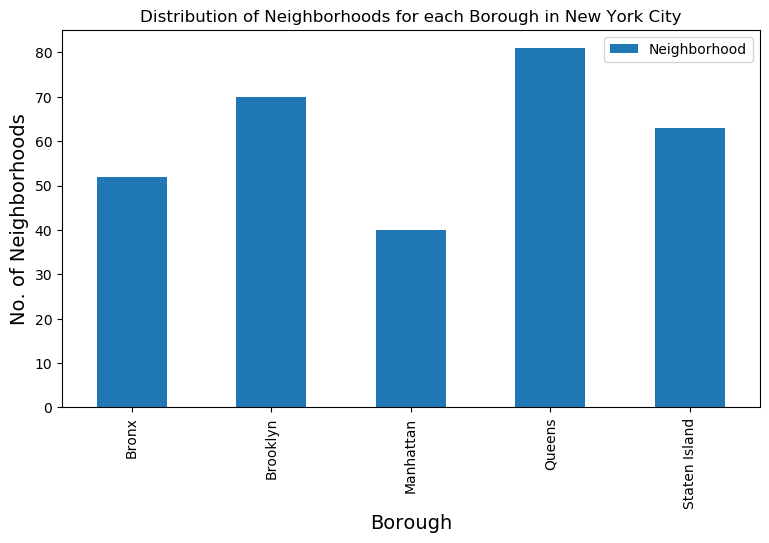

In [22]:
plt.figure(figsize=(9,5), dpi = 100)

plt.title('Distribution of Neighborhoods for each Borough in New York City')

plt.xlabel('Boroughs',fontsize=14)
plt.ylabel('No. of Neighborhoods',fontsize=14)
ny_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

#### Queens seems to have highest number of Neighborhoods.

We will start collecting venues from each neighborhood in each borough using get_venues() function we previously defined and filter them by category of 'Indian Restaurant' and store in ir_ny dataframe.

In [43]:
column_names = ['Borough','Neoghborhood','ID','Name']
ir_ny = pd.DataFrame(columns=column_names)

for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude = row
    venues = get_venues(Latitude,Longitude)
    ir_category = venues[venues['Category']=='Indian Restaurant']
    print('No. of Inidan Restarants in ',Neighborhood,', ',Borough,':',str(len(ir_category)))
    
    for restaurant in ir_category.values.tolist():
        id, name, category = restaurant
        ir_ny = ir_ny.append({'Borough':Borough,
                              'Neighborhood':Neighborhood,
                              'ID':id,
                              'Name':name
                             },ignore_index=True)

No. of Inidan Restarants in  Wakefield ,  Bronx : 0
No. of Inidan Restarants in  Co-op City ,  Bronx : 0
No. of Inidan Restarants in  Eastchester ,  Bronx : 0
No. of Inidan Restarants in  Fieldston ,  Bronx : 0
No. of Inidan Restarants in  Riverdale ,  Bronx : 0
No. of Inidan Restarants in  Kingsbridge ,  Bronx : 0
No. of Inidan Restarants in  Marble Hill ,  Manhattan : 0
No. of Inidan Restarants in  Woodlawn ,  Bronx : 1
No. of Inidan Restarants in  Norwood ,  Bronx : 0
No. of Inidan Restarants in  Williamsbridge ,  Bronx : 0
No. of Inidan Restarants in  Baychester ,  Bronx : 0
No. of Inidan Restarants in  Pelham Parkway ,  Bronx : 0
No. of Inidan Restarants in  City Island ,  Bronx : 0
No. of Inidan Restarants in  Bedford Park ,  Bronx : 0
No. of Inidan Restarants in  University Heights ,  Bronx : 0
No. of Inidan Restarants in  Morris Heights ,  Bronx : 0
No. of Inidan Restarants in  Fordham ,  Bronx : 0
No. of Inidan Restarants in  East Tremont ,  Bronx : 0
No. of Inidan Restarants 

In [44]:
ir_ny.head()

,Borough,Neoghborhood,ID,Name,Neighborhood
0,Bronx,NaN,4c0448d9310fc9b6bf1dc761,Curry Spot,Woodlawn
1,Bronx,NaN,551b7f75498e86c00a0ed2e1,Hungry Bird,Melrose
2,Bronx,NaN,551b7f75498e86c00a0ed2e1,Hungry Bird,Morrisania
3,Brooklyn,NaN,4b5a4dc8f964a520a2bb28e3,Taj Mahal,Bay Ridge
4,Brooklyn,NaN,4af0d31bf964a5207ddf21e3,Pak Nasheman,Brighton Beach


#### SMH, one typo and an unnecessary column added! Let's drop it. (Totally aware that I should remove this and retype stuff but letting it stay anyway)

In [45]:
ir_ny.drop(['Neoghborhood'],axis=1,inplace=True)
ir_ny.head()

,Borough,ID,Name,Neighborhood
0,Bronx,4c0448d9310fc9b6bf1dc761,Curry Spot,Woodlawn
1,Bronx,551b7f75498e86c00a0ed2e1,Hungry Bird,Melrose
2,Bronx,551b7f75498e86c00a0ed2e1,Hungry Bird,Morrisania
3,Brooklyn,4b5a4dc8f964a520a2bb28e3,Taj Mahal,Bay Ridge
4,Brooklyn,4af0d31bf964a5207ddf21e3,Pak Nasheman,Brighton Beach


In [46]:
ir_ny.shape

(151, 4)

#### We have 151 Indian Restaurants in NY, let's see the distribution with respect to boroughs

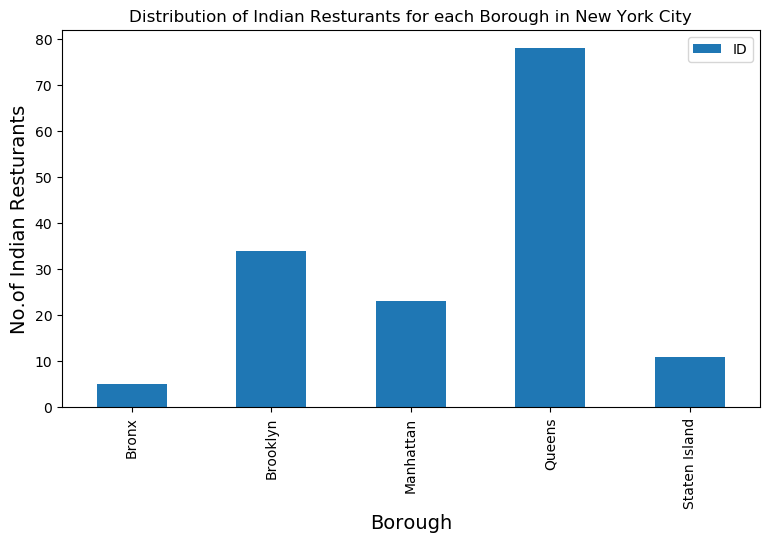

In [47]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Distribution of Indian Resturants for each Borough in New York City')
plt.xlabel('Borough', fontsize = 14)
plt.ylabel('No.of Indian Resturants', fontsize=14)

ir_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

#### We can see that Queens has the highest number of Indian restaurants. Let's see which Neighborhood has the highest number.

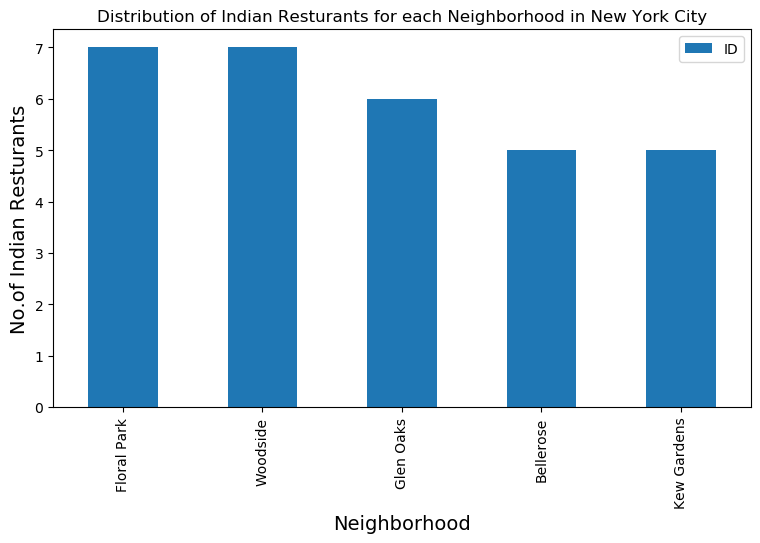

In [51]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Distribution of Indian Resturants for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 14)
plt.ylabel('No.of Indian Resturants', fontsize=14)
ir_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

In [52]:
ir_ny[ir_ny['Neighborhood']=='Floral Park']

,Borough,ID,Name,Neighborhood
103,Queens,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen,Floral Park
104,Queens,527ffc0811d2d329d5e49abd,Jackson Diner,Floral Park
105,Queens,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets,Floral Park
106,Queens,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant,Floral Park
107,Queens,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress,Floral Park
108,Queens,4b9030abf964a520397b33e3,Taste of Cochin,Floral Park
109,Queens,506799e4e4b08b705a04234d,Jassi's Fine Indian Cuisine,Floral Park


#### Floral Park in Queens has the highest number of Indian Restaurants.

Let's fetch rating and other performance parameters for all the restaurants.

In [56]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
ir_perf_ny=pd.DataFrame(columns=column_names)

for row in ir_ny.values.tolist():
    Borough,ID,Name,Neighborhood=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    ir_perf_ny = ir_perf_ny.append({'Borough': Borough,
                                    'Neighborhood': Neighborhood, 
                                    'ID': id,
                                    'Name' : name,
                                    'Likes' : likes,
                                    'Rating' : rating,
                                    'Tips' : tips
                                    }, ignore_index=True)

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.8    11
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.9     3
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.9     3
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     38     8.4    26
                         ID          Name  Likes  Rating  Tips
0  4af0d31bf964a5207ddf21e3  Pak Nasheman      9     7.2     4
                         ID          Name  Likes  Rating  Tips
0  52213c4211d295d4c57a607c  Ashoka Grill      8     7.3    14
                         ID       Name  Likes  Rating  Tips
0  4db0f4371e729fcc56497f20  Mashallah     19     7.6     7
                         ID                     Name  Likes  Rating  Tips
0  519ff6c8498e1300ddcbd45c  Anarkali Indian Cuisine     14     

In [57]:
ir_perf_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.8,11
1,Bronx,Melrose,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.9,3
2,Bronx,Morrisania,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.9,3
3,Brooklyn,Bay Ridge,4b5a4dc8f964a520a2bb28e3,Taj Mahal,38,8.4,26
4,Brooklyn,Brighton Beach,4af0d31bf964a5207ddf21e3,Pak Nasheman,9,7.2,4


In [58]:
ir_perf_ny.shape

(151, 7)

#### As the number of calls to get details for venue are premium call and have limit of 500 per day, we will save the data to a csv for reference in case we make a mistake/unnecessary modification.

In [59]:
ir_perf_ny.to_csv('ir_perf_ny.csv', index=False)

Let's check our dataframe and see if any modifications are requires since we are gonna have to deal with ratings, we don't want it to be in int.

In [61]:
ir_perf_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 7 columns):
Borough         151 non-null object
Neighborhood    151 non-null object
ID              151 non-null object
Name            151 non-null object
Likes           151 non-null object
Rating          151 non-null float64
Tips            151 non-null object
dtypes: float64(1), object(6)
memory usage: 8.4+ KB


In [62]:
ir_perf_ny[['Likes','Tips']] = ir_perf_ny[['Likes','Tips']].apply(pd.to_numeric)
ir_perf_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 7 columns):
Borough         151 non-null object
Neighborhood    151 non-null object
ID              151 non-null object
Name            151 non-null object
Likes           151 non-null int64
Rating          151 non-null float64
Tips            151 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 8.4+ KB


### Now that we have all the ratings of Indian Restaurants for the NY city, let's say that the client has decided to check results for a strategy which is by assuming that setting up a new restaurant in a place where the competitors aren't too many and their performance is average or less, there is a high chance that the more customers will be coming in and hence more revenue could be generated, provided that the restaurant has variety of dishes, taste and quality is better than the most.

#### Let's check out Neighborhood and Borough wise top average ratings.

In [63]:
ny_borough_perf=ir_perf_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_perf.columns=['Borough','Average Rating']
ny_borough_perf.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.321739
3,Queens,7.648718
1,Brooklyn,7.597059
4,Staten Island,7.200000
0,Bronx,7.080000


In [67]:
ny_neighborhood_perf=ir_perf_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_perf.columns=['Neighborhood','Average Rating']
ny_neighborhood_perf.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
6,Blissville,9.1
13,Civic Center,9.1
69,Soho,9.1
77,Tribeca,9.1
0,Astoria,9.0
15,Clinton Hill,8.8
29,Fort Greene,8.8
4,Bedford Stuyvesant,8.8
78,Tudor City,8.7
17,Crown Heights,8.7


#### Given that client is looking for results of average or less ratings of restaurants, let's see all the neighborhoods with average rating lesser or equal 7.0 to visualize on map which could give give us an idea about where to setup a restaurant and where to setup next should the revenue turns out very good for the first restaurant.

In [68]:
ny_neighborhood_perf=ny_neighborhood_perf[ny_neighborhood_perf['Average Rating']<=7.0]
ny_neighborhood_perf

,Neighborhood,Average Rating
1,Auburndale,6.80
5,Bellerose,5.72
12,City Line,0.00
14,Claremont Village,6.90
16,Concourse Village,6.90
18,Cypress Hills,0.00
22,Egbertville,4.05
43,Kew Gardens Hills,6.70
48,Melrose,6.90
51,Morrisania,6.90


Let's join the neighborhoods on our original datadet to get coordinates.

In [69]:
ny_neighborhood_perf = pd.merge(ny_neighborhood_perf,ny_data,on='Neighborhood')
ny_neighborhood_perf = ny_neighborhood_perf[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_perf

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Auburndale,40.761730,-73.791762,6.80
1,Queens,Bellerose,40.728573,-73.720128,5.72
2,Brooklyn,City Line,40.678570,-73.867976,0.00
3,Bronx,Claremont Village,40.831428,-73.901199,6.90
4,Bronx,Concourse Village,40.824780,-73.915847,6.90
5,Brooklyn,Cypress Hills,40.682391,-73.876616,0.00
6,Staten Island,Egbertville,40.579119,-74.127272,4.05
7,Queens,Kew Gardens Hills,40.722578,-73.820878,6.70
8,Bronx,Melrose,40.819754,-73.909422,6.90
9,Bronx,Morrisania,40.823592,-73.901506,6.90


We can display the neighborhood, borough and avg ratings on each marker that will be helpful in making business decisions.

In [74]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=11)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_perf[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
ny_neighborhood_perf['Label']=ny_neighborhood_perf['Neighborhood'] + ', '+ ny_neighborhood_perf['Borough'] + '('+ ny_neighborhood_perf['Average Rating'].map(str) + ')'
    
for lat, lng, label in ny_neighborhood_perf[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

<img src="neighborhood ratings.jpg" width="800">

This is the screenshot of the map generated.

#### Mostly, maps can't be seen in github, I have attached the screenshot anyway or you can view the same in Jupyter's [nbviewer](https://nbviewer.jupyter.org/). Just paste the github link of this notebook in the nbviewer page and you are good to go!

#### Now, we may notice that some restaurants have 0 ratings, which could be due to the places in the neighborhoods being new restaurants or not yet rated.

#### Let's see a Choropleth map borough wise. The map generated will be very large and can't be displayed, so we will be saving the file and display an image of the same. Feel free to check out the html file from the repo.

In [77]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=11)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_perf,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')
# ny_map

<img src="borough_rating.jpg" width="800">

This is the screenshot of the map generated. You can still access the html from [here](https://github.com/amarkt/Coursera_Capstone/blob/master/borough_rating.html). You need to download it and open it to see the map.

### We can notice that we have not seen any results of ratings<7 shown up in Manhattan borough. This would mean that there are top and aggressive competitors in that borough and would not be a very good start for our client to start setting up in Manhattan and gain popularity among customers and generate good revenue. On the other hand, the client can still check out other boroughs and neighborhoods accordingly to see where would be a great start for the restaurant and branch out later on.

## Conclusion:
- We can see that Brooklyn, Queens and Bronx could be a very good start for our client to gain popularity and revenue with a new restaurant there. After a certain amount of time, with sufficient funds, the client can look forward to branch out more restaurants in other neighborhoods and boroughs.

## Limitations:
- We may have missed out on potential competitors by the probability that they're new and haven't been rated or recorded in Foursquare database.